# Import libraries

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import datasets, transforms
import torchinfo
# Note: this notebook requires torch >= 1.10.0
torch.__version__

In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Variable definition

In [6]:
import easydict
args = easydict.EasyDict

args.default_path ="/content/data/MyDrive/Projects/Kaggle_IceBerg/"
args.train_json = args.default_path + 'datas/train.json'
args.test_json = args.default_path + 'datas/test.json'
args.default_submission_csv = args.default_path + 'datas/sample_submission.csv'
args.save_submission = args.default_path + 'result/submission.csv'

args.random_state = 42

# Load data

In [7]:
train_data = pd.read_json(args.train_json)
test_data = pd.read_json(args.test_json)

In [8]:
test_data.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [9]:
train_data.shape, test_data.shape

((1604, 5), (8424, 4))

# Feature extraction

- band1: 입사각이 수직이 되는 위치에서 피사체에 레이저 조명
> 레이저가 닿는 표면의 굴곡에 따라 결과값의 차이가 큼 
- band2: 입사각이 inc_angle이 되는 위치에서 피사체에 레이저 조명
- inc_angle: 입사각
- is_iceberg: ship or iceberg, target



In [10]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_2']])

X_test_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_1']])
X_test_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_2']])

In [11]:
# band1, 2의 각 픽셀 값을 비교해 min, max column 생성
min_train = np.array([np.array(min(band1, band2)).astype(np.float32).reshape(75,75) for band1, band2 in zip(train_data.band_1, train_data.band_2)])
max_train = np.array([np.array(max(band1, band2)).astype(np.float32).reshape(75,75) for band1, band2 in zip(train_data.band_1, train_data.band_2)])

min_test = np.array([np.array(min(band1, band2)).astype(np.float32).reshape(75,75) for band1, band2 in zip(test_data.band_1, test_data.band_2)])
max_test = np.array([np.array(max(band1, band2)).astype(np.float32).reshape(75,75) for band1, band2 in zip(test_data.band_1, test_data.band_2)])

- min, max 컬럼이 피사체의 형태를 단순화시켜 줄 거라 예상하였으나 모델 정확도에 좋은 영향을 주지 않음
- band1, band2, 두 band의 평균을 axis -1에서 concatenate하여 channel 3개로 변환 -> 상관 관계가 있는 3개의 데이터를 feature 처럼 사용함

In [99]:
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis],X_band_2[:,:,:,np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
X_test = np.concatenate([X_test_band_1[:, :, :, np.newaxis],X_test_band_2[:,:,:,np.newaxis],((X_test_band_1+X_test_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

# Costom dataset

train dataset, val_dataset, test_datset을 위한 custom data 함수 생성

In [84]:
class CustomDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels
        if self.transform:
            image = self.transform(image)
        if label is None:
          return image
        label = self.labels[idx]
        return image, label

이미지 사이즈 64*64로 변환한 후 정규화 

In [160]:
#transformations
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64,64)),                               
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((64,64)),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

In [100]:
# costom dataset에 적용해줄 데이터 프레임 

labels = train_data.is_iceberg.copy() # train data에서 가져온 label 

df = pd.DataFrame(columns = ['img_path', 'label'])
df['img_path'] = [np.array(img) for img in list(X_train)]
df['label'] = labels

test_df = pd.DataFrame(columns = ['img_path'])
test_df.img_path = [np.array(img) for img in list(X_test)]

In [101]:
# train, validation split 
tr, val, _, _ = train_test_split(df, df.label, test_size=0.3, stratify=df.label, random_state=42)

In [165]:
train_dataset = CustomDataset(tr['img_path'].values, tr['label'].values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

test_dataset = CustomDataset(data = test_df['img_path'].values,transform = test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Model

## BasicBlock

In [169]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() 
        # f(x)와 형태가 다른 x가 등장하면 매트릭스 연산이 가능하도록 shape을 변환 
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # L1: (conv + bn) -> relu
        out = self.bn2(self.conv2(out)) # L2: (conv + bn)
        out += self.shortcut(x) # shortcut으로 shape맞춰준 residual(X)과 합치기 
        out = F.relu(out)
        return out

## Resnet18

In [170]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # BatchNorm2d: 각 배치가 데이터의 분포에 따라 형태가 달라지기 때문에 배치들의 형태를 정규화함 
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers) # 가변 list를 받아서 순서대로 실행 

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1) # 첫 번째 차원 제외하고 모든 차원 제거 -> 벡터화 
        # view = reshape: flatten, tensor 차원 변환 
        out = self.linear(out)
        return out

In [171]:
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [172]:
num_classes = 1

torch.manual_seed(42)
model_0 = ResNet18(num_classes).to(device)
model_0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [175]:
torchinfo.summary(model_0,(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 64, 64]          1,728
├─BatchNorm2d: 1-2                       [32, 64, 64, 64]          128
├─Sequential: 1-3                        [32, 64, 64, 64]          --
│    └─BasicBlock: 2-1                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          128
│    │    └─Conv2d: 3-3                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-4             [32, 64, 64, 64]          128
│    │    └─Sequential: 3-5              [32, 64, 64, 64]          --
│    └─BasicBlock: 2-2                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-6                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-7             [32, 64, 64, 64]          

## Inference before training

In [173]:
img_batch, label_batch = next(iter(train_loader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()

with torch.inference_mode():
    pred = torch.sigmoid(model_0(img_single.to(device))) # binary classification은 sigmoid적용 

print(f"Output logits:\n{pred}\n")
print(f"Output prediction label:\n{torch.round(pred)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.8924]], device='cuda:0')

Output prediction label:
tensor([[1.]], device='cuda:0')

Actual label:
1


## Create train & test loop functions

In [114]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device) 
        y = y.unsqueeze(1).float() # X, y 차원 맞춰줌 
        y = y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.round(torch.sigmoid(y_pred))
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [115]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X = X.to(device) 
            y = y.unsqueeze(1).float()
            y = y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits)) # acc 제대로 안나옴 고쳐야함(sigmoid)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

In [116]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "best_model_wts":''
    }
    min_test_losses = 1

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 최적 가중치 기록 
        if test_loss <= min_test_losses:
            results["best_model_wts"] = model.state_dict()
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        min_test_losses = min(results['test_loss'])
    return results

## Train and Evaluate Model 0

In [174]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_0 = ResNet18(1).to(device)

loss_fn = nn.BCEWithLogitsLoss() # binary classification loss function 
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6252 | train_acc: 0.6606 | test_loss: 0.5486 | test_acc: 0.6836
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.7665 | test_loss: 0.4840 | test_acc: 0.7559
Epoch: 3 | train_loss: 0.4558 | train_acc: 0.7778 | test_loss: 0.4762 | test_acc: 0.7793
Epoch: 4 | train_loss: 0.3874 | train_acc: 0.8281 | test_loss: 0.7305 | test_acc: 0.7754
Epoch: 5 | train_loss: 0.3443 | train_acc: 0.8550 | test_loss: 0.3298 | test_acc: 0.8359
Epoch: 6 | train_loss: 0.2809 | train_acc: 0.8733 | test_loss: 0.3837 | test_acc: 0.8203
Epoch: 7 | train_loss: 0.2384 | train_acc: 0.9036 | test_loss: 0.3622 | test_acc: 0.8398
Epoch: 8 | train_loss: 0.2189 | train_acc: 0.9141 | test_loss: 1.7177 | test_acc: 0.6562
Epoch: 9 | train_loss: 0.2081 | train_acc: 0.9115 | test_loss: 0.3467 | test_acc: 0.8691
Epoch: 10 | train_loss: 0.2252 | train_acc: 0.9193 | test_loss: 0.5880 | test_acc: 0.7988
Epoch: 11 | train_loss: 0.1946 | train_acc: 0.9271 | test_loss: 0.3789 | test_acc: 0.8477
Epoch: 12 | train_l

In [121]:
img_batch, label_batch = next(iter(train_loader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()

with torch.inference_mode():
    pred = torch.sigmoid(model_0(img_single.to(device)))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction label:\n{torch.round(pred)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.8467]], device='cuda:0')

Output prediction label:
tensor([[1.]], device='cuda:0')

Actual label:
1


## Plot the loss curves of Model 0

In [138]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

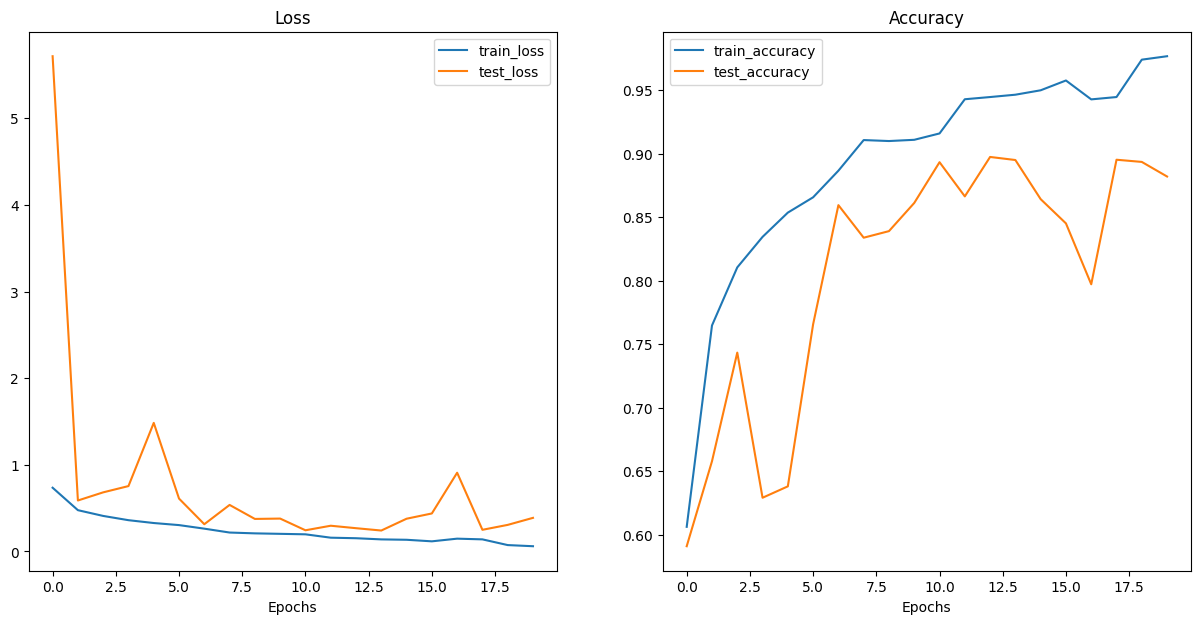

In [139]:
plot_loss_curves(model_0_results)

# Prediction

In [140]:
# 최적 모델 가중치 적용
model_0.load_state_dict(model_0_results['best_model_wts'])

<All keys matched successfully>

In [177]:
pred_data = []

model_0.eval()

# test_loader에서 batch만큼 가져와 예측 진행 
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model_0(images))
        pred_data.extend(outputs.squeeze().tolist())

len(pred_data)

In [144]:
submission = pd.read_csv(args.default_submission_csv)
submission = submission.set_index('id')
submission.is_iceberg = pred_data
submission.head()

In [147]:
submission.to_csv(args.save_submission)